# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
!pip install -q phik

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
from scipy import stats as st

import matplotlib
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    recall_score,
    r2_score,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay,
    make_scorer
)
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from lightgbm import LGBMRegressor
import time


In [4]:
RANDOM_STATE = 42

In [5]:
data_auto = pd.read_csv("/datasets/autos.csv")

In [6]:
display(data_auto.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
data_auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [8]:
data_auto.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

**Итоги по обзору данных:**
* Присутствуют пропуски в vehicle_type, gearbox, model, fuel_type, repaired
* Присутствуют проблемы с форматом столбцов данных

# Предобработка данных


In [9]:
def col_rename(data):
    col_new = []
    for col in data.columns:
        count = 0
        name = ""
        for c in col:
            if c.isupper():
                count += 1
                if count > 1:
                    name += "_"
            name += c
        col_new.append(name.lower())
    data.columns = col_new
    return data

def print_duplicates(data):
    for col in data.columns:
        if data[col].dtype == 'object':
            print(f"{col}: {data[col].unique()}")

In [10]:
col_rename(data_auto)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [11]:
data_auto.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

In [12]:
data_auto["vehicle_type"] = data_auto["vehicle_type"].fillna("unknown")
data_auto["gearbox"] = data_auto["gearbox"].fillna("unknown")
data_auto["model"] = data_auto["model"].fillna("unknown")
data_auto["fuel_type"] = data_auto["fuel_type"].fillna("unknown")
data_auto["repaired"] = data_auto["repaired"].fillna("unknown")

In [13]:
data_auto.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

In [14]:
data_auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        354369 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             354369 non-null  object
 5   power               354369 non-null  int64 
 6   model               354369 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           354369 non-null  object
 10  brand               354369 non-null  object
 11  repaired            354369 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [15]:
data_auto["date_crawled"] = pd.to_datetime(data_auto["date_crawled"], format = '%Y-%m-%d %H:%M:%S')
data_auto["date_created"] = pd.to_datetime(data_auto["date_created"], format = '%Y-%m-%d %H:%M:%S')
data_auto["last_seen"] = pd.to_datetime(data_auto["last_seen"], format = '%Y-%m-%d %H:%M:%S')

In [16]:
data_auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354369 non-null  datetime64[ns]
 1   price               354369 non-null  int64         
 2   vehicle_type        354369 non-null  object        
 3   registration_year   354369 non-null  int64         
 4   gearbox             354369 non-null  object        
 5   power               354369 non-null  int64         
 6   model               354369 non-null  object        
 7   kilometer           354369 non-null  int64         
 8   registration_month  354369 non-null  int64         
 9   fuel_type           354369 non-null  object        
 10  brand               354369 non-null  object        
 11  repaired            354369 non-null  object        
 12  date_created        354369 non-null  datetime64[ns]
 13  number_of_pictures  354369 no

In [17]:
display(data_auto.loc[data_auto.duplicated()])

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15


In [18]:
data_auto = data_auto.drop_duplicates(keep="first").reset_index(drop=True)

In [19]:
display(data_auto.loc[data_auto.duplicated()])

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen


In [20]:
print_duplicates(data_auto)

vehicle_type: ['unknown' 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon'
 'other']
gearbox: ['manual' 'auto' 'unknown']
model: ['golf' 'unknown' 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max'
 '3_reihe' 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco'
 '5er' 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse'
 'clio' 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 '

**Итоги по предобработке данных:**
* Тип данных был приведен в верный формат
* Названия столбцов были переведены в змеиный регистр
* Пропуски были заменены заглушкой unknown
* Явные дубликаты были устранены
* Неявных дубликатов нет

# Исследовательский анализ данных

In [21]:
def plot_hist(data, name, number=None, x_beg=None, x_end=None, palette=None):
    series = data[name]
    if number is None:
        q75, q25 = np.percentile(series, [75, 25])
        iqr = q75 - q25
        bin_width = 2 * iqr / (len(series) ** (1/3))
        if bin_width:
            number = int((series.max() - series.min()) / bin_width)
        else:
            number = 10  
            
    if x_beg is not None and x_end is not None:
        series = series[(series >= x_beg) & (series <= x_end)]
        
    plt.figure(figsize=(10, 5))
    sns.histplot(
        series,
        bins=number,
        kde=True,
        edgecolor='black',
        color='darkcyan',
        palette=palette
    )
    
    plt.title(f"Гистограмма для '{name}'", fontsize=14, fontweight='bold')
    plt.xlabel(name, fontsize=12)
    plt.ylabel("Частота", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    
    
def plot_box(data, name):
    series = data[name]
    q1 = np.percentile(series, 25)
    q3 = np.percentile(series, 75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    plt.figure(figsize=(10, 5))
    plt.title(f"Boxplot для '{name}'", fontsize=14, fontweight='bold')
    plt.ylabel(name, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    
    flierprops = dict(marker='o', markerfacecolor='red', markersize=5, linestyle='none')
    plt.boxplot(series, vert=True, patch_artist=True,
                boxprops=dict(facecolor='darkcyan', color='black'),
                medianprops=dict(color='black'),
                whiskerprops=dict(color='black'),
                capprops=dict(color='black'),
                flierprops=flierprops)

    plt.tight_layout()
    plt.show()
    
def plot_pie(data, name, top_n=7):
    count = data[name].value_counts()
    if len(count) > top_n:
        other_sum = count[top_n:].sum()
        count = count[:top_n]
        count["Другие"] = other_sum

    plt.figure(figsize=(10, 7))
    
    colors = sns.color_palette("Set2", len(count)) 
    explode = [0.08] * (len(count) - 1) + [0.2]
    
    wedges, texts, autotexts = plt.pie(
        count, 
        labels=count.index, 
        autopct=lambda p: f"{p:.1f}%" if p > 2 else "",
        startangle=140, 
        colors=colors, 
        explode=explode, 
        shadow=True, 
        wedgeprops={'edgecolor': 'black', 'linewidth': 1}
    )
 
    for text in texts:
        text.set_fontsize(12)
        text.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='none'))
    plt.title(f"Круговая диаграмма для '{name}'", fontsize=14, fontweight="bold")
    plt.show()
    
def plot_bar(data, name, sort=True):
    counts = data[name].value_counts()

    if sort:
        counts = counts.sort_values(ascending=False)
    else:
        counts = counts.sort_index()
        
    plt.figure(figsize=(10, max(5, len(counts) * 0.3)))
    counts.plot(kind='barh', color="darkcyan", edgecolor='black')
    plt.title(f"Горизонтальная диаграмма для '{name}'", fontsize=14, fontweight='bold')
    plt.xlabel("Частота", fontsize=12)
    plt.ylabel(name, fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    
def delete_outliers(data, name, lower, upper):
    initial = data[name].count()
    data = data.query(f"{name} < {lower} or {name} > {upper}")
    final = data[name].count()
    percent = (1 - (final / initial)) * 100
    print(f"Доля удалённых значений: {percent:.2f}%")
    data = data.reset_index(drop=True)
    return data

def check_outliers(data, name, lower, upper):
    total = data[name].count()
    inside_range = data.query(f"{lower} <= {name} <= {upper}")[name].count()
    percent = (inside_range / total) * 100
    print(f"Доля значений внутри диапазона [{lower}, {upper}]: {percent:.2f}%")
    
def replace_outliers(data, name, lower, upper, check):
    in_range = (data[name] >= lower) & (data[name] <= upper)
    out_range = ~in_range
    if check == 1:
        clean_mean = round(data.loc[out_range, name].mean())
    else:
        clean_mean = data.loc[out_range, name].mean()
    data.loc[in_range, name] = clean_mean
    return data

In [22]:
data_auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354365 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        354365 non-null  datetime64[ns]
 1   price               354365 non-null  int64         
 2   vehicle_type        354365 non-null  object        
 3   registration_year   354365 non-null  int64         
 4   gearbox             354365 non-null  object        
 5   power               354365 non-null  int64         
 6   model               354365 non-null  object        
 7   kilometer           354365 non-null  int64         
 8   registration_month  354365 non-null  int64         
 9   fuel_type           354365 non-null  object        
 10  brand               354365 non-null  object        
 11  repaired            354365 non-null  object        
 12  date_created        354365 non-null  datetime64[ns]
 13  number_of_pictures  354365 no

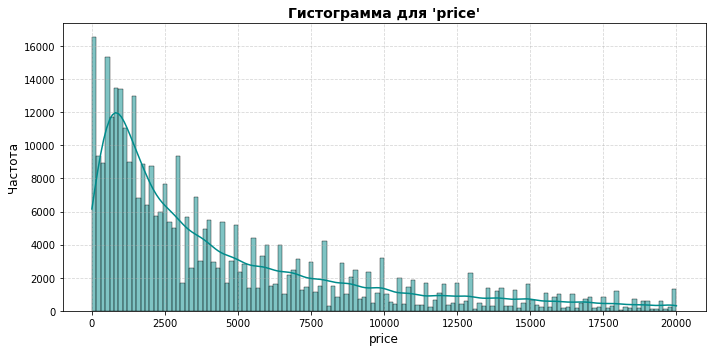

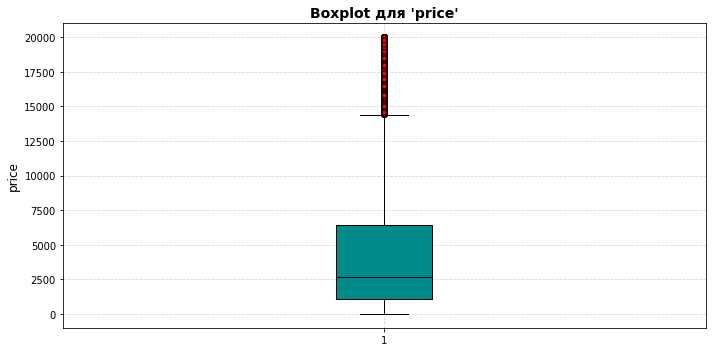

count    354365.000000
mean       4416.679830
std        4514.176349
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

In [23]:
plot_hist(data_auto, "price")
plot_box(data_auto, "price")
data_auto["price"].describe()

С увеличением цены машины понижается их количество, что не вызывает никаких отклонений от нормы. Машины, которые стоят больше 14500 посчитались выбросами из-за маленького количества дорогих машин по отношению к общему. Их мы обрабатывать не будем, но присмотримся к слишком дешевым машинам, которые стоят 0. Cреднее значение равно 4416, а медиана 2700. Максимальное и минимальное значение 20000 и 0 евро.

In [24]:
check_outliers(data_auto, "price", 0, 250)

Доля значений внутри диапазона [0, 250]: 6.26%


Если удалить значения в диапазоне от 0 до 250, то их доля будет слишком большой, поэтому следует заменить их средним значением.

In [25]:
data_auto = replace_outliers(data_auto, "price", 0, 250, 0)

In [26]:
data_auto["price"].describe()

count    354365.000000
mean       4706.419324
std        4372.654872
min         251.000000
25%        1400.000000
50%        3350.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

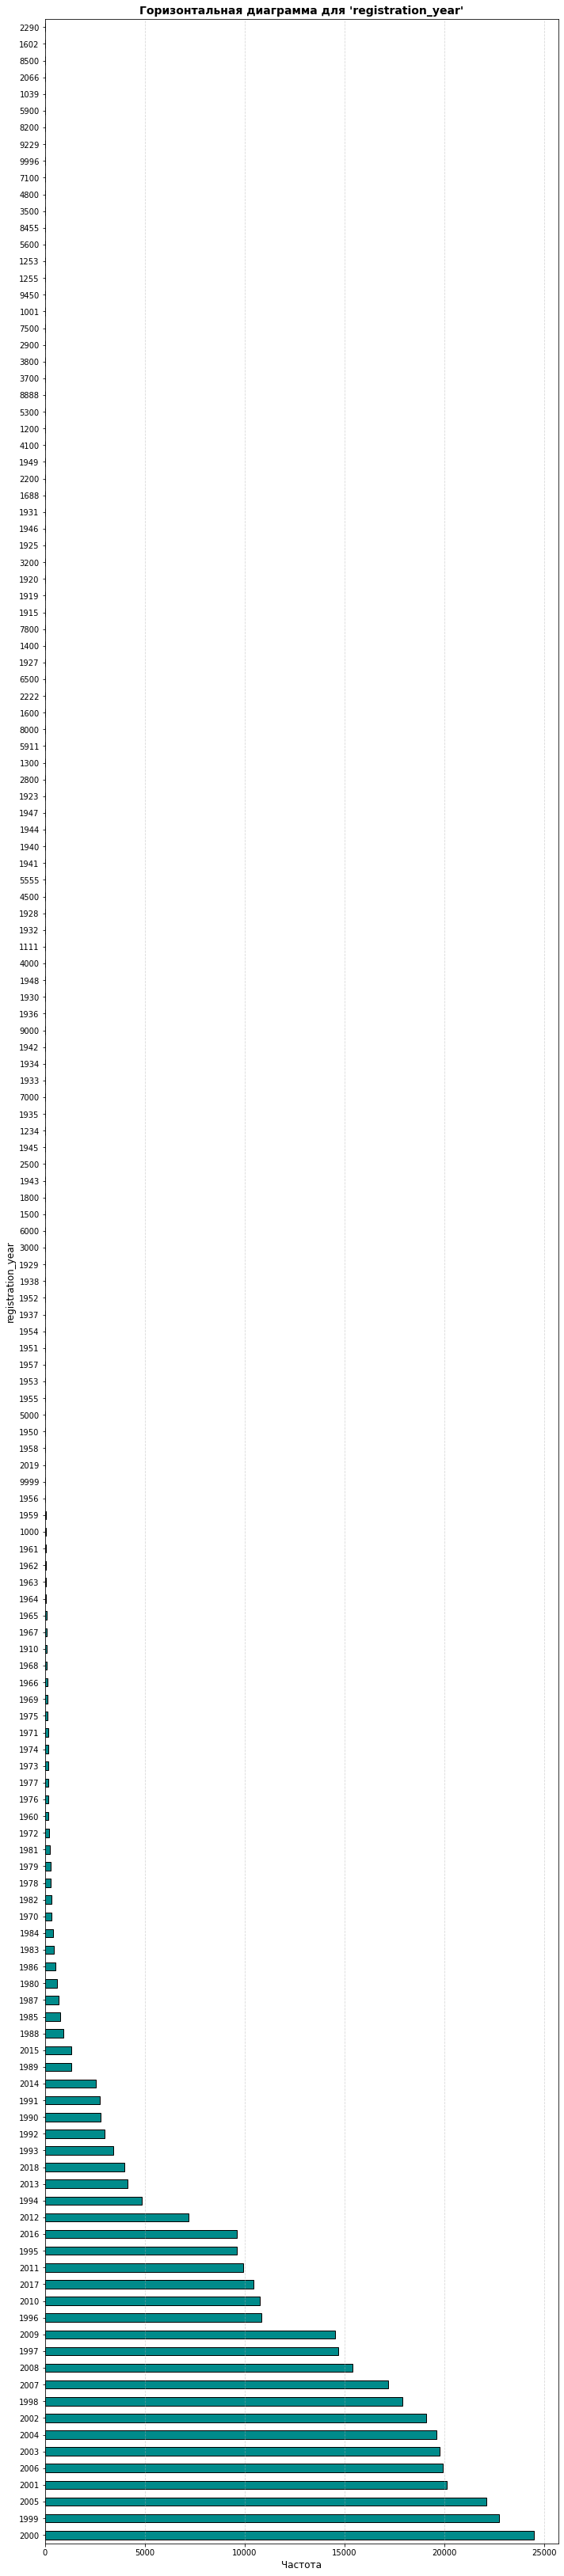

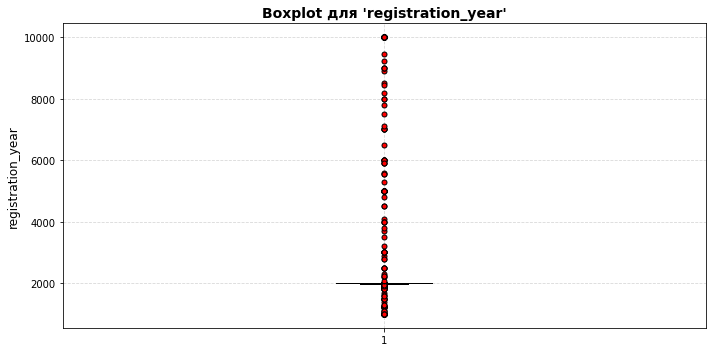

count    354365.000000
mean       2004.234481
std          90.228466
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: registration_year, dtype: float64

In [27]:
plot_bar(data_auto, "registration_year")
plot_box(data_auto, "registration_year")
data_auto["registration_year"].describe()

Мы видим множество аномальных значений. Например: год регистрации не может быть 9999 или 1000. Самым частым годом регистрации машины является 2000, а следом 1999, 2005, 2006 и 2001.

In [28]:
data_auto = delete_outliers(data_auto, "registration_year", 0, 1959)

Доля удалённых значений: 0.12%


In [29]:
data_auto = delete_outliers(data_auto, "registration_year", 2019, 9999)

Доля удалённых значений: 0.04%


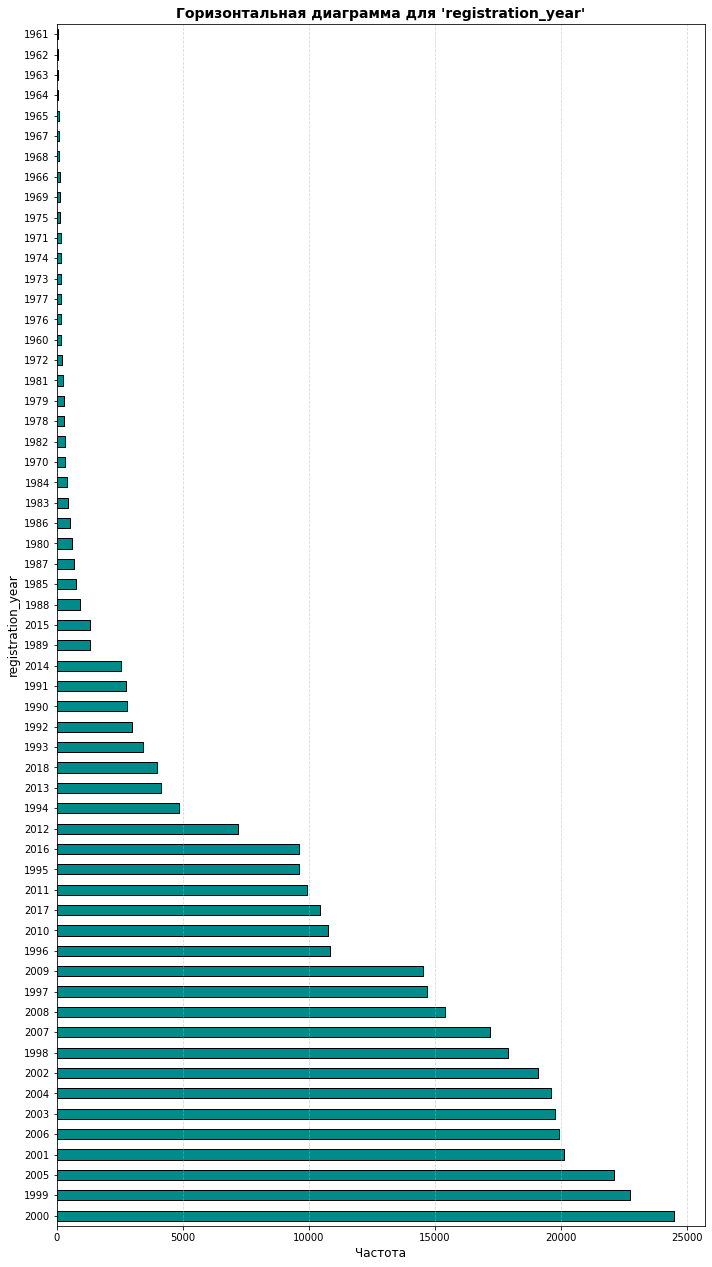

In [30]:
plot_bar(data_auto, "registration_year")

Слишком большие и слишком маленькие года были удалены из датасета.

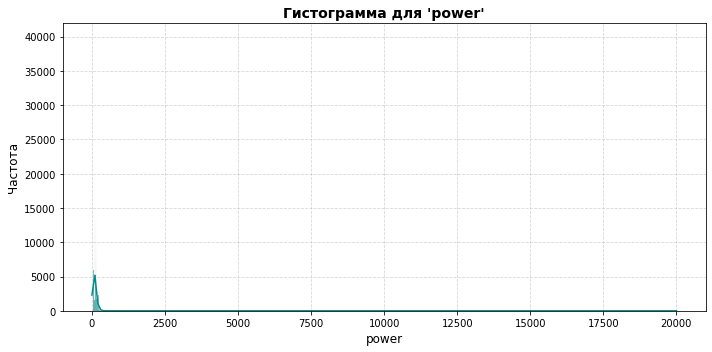

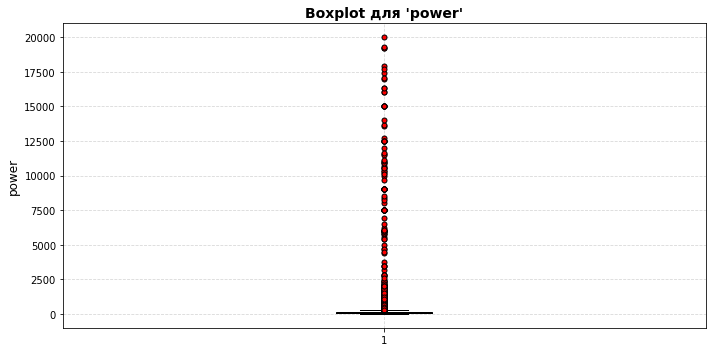

count    353813.000000
mean        110.150503
std         189.589432
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

In [31]:
plot_hist(data_auto, "power")
plot_box(data_auto, "power")
data_auto["power"].describe()

In [32]:
data_auto = delete_outliers(data_auto, "power", 2000, 20000)

Доля удалённых значений: 0.03%


In [33]:
check_outliers(data_auto, "power", 0, 50)

Доля значений внутри диапазона [0, 50]: 14.24%


In [34]:
data_auto = replace_outliers(data_auto, "power", 0, 50, 0)

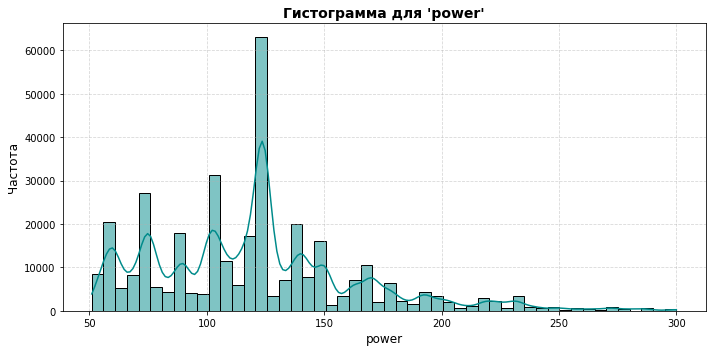

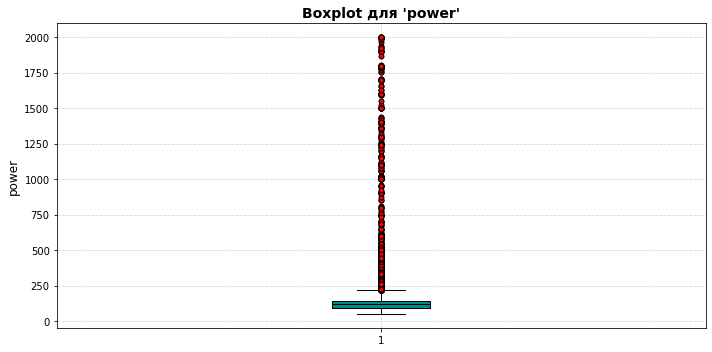

count    353691.000000
mean        123.694064
std          58.252891
min          51.000000
25%          90.000000
50%         123.694064
75%         143.000000
max        1999.000000
Name: power, dtype: float64

In [35]:
plot_hist(data_auto, "power", 50, 0, 300)
plot_box(data_auto, "power")
data_auto["power"].describe()

Значения мощности автомобиля выше 2000 было принято считать за выбросы. Их доля составляет 0.03%. В тоже время доля значений меньше 50 составляет 14.24%. Из-за большой доли таких аномальных значений они были заменены средним значением. Медиана и среднее значение равны 123.69 и 123.69. Максимальное и минимальное значения равны 51 и 1999 л.с

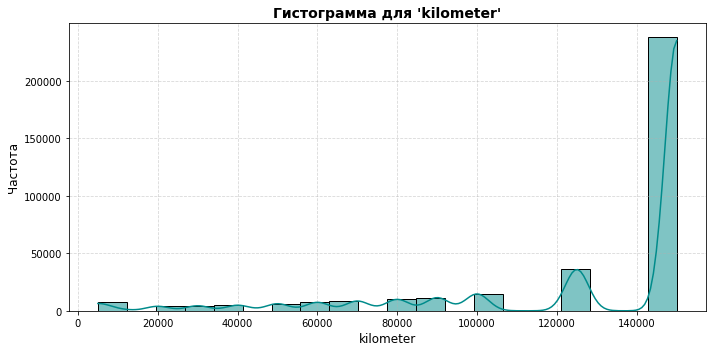

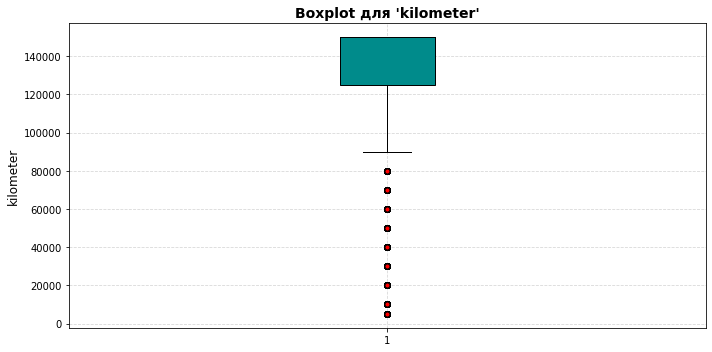

count    353691.000000
mean     128335.708288
std       37737.763424
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

In [36]:
plot_hist(data_auto, "kilometer", 20)
plot_box(data_auto, "kilometer")
data_auto["kilometer"].describe()

Никаких аномальных значений в пробеге не наблюдается. Присутствует много значений с большим пробегом и мало значений с маленьким пробегом. Медиана и среднее значение равны 128335 и 15000. Максимальное и минимальное значения равны 5000 и 15000 л.с

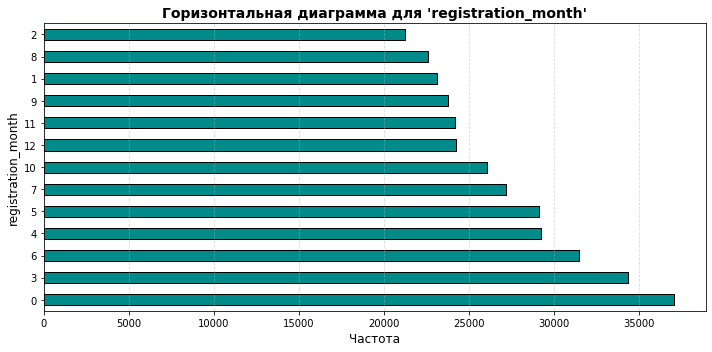

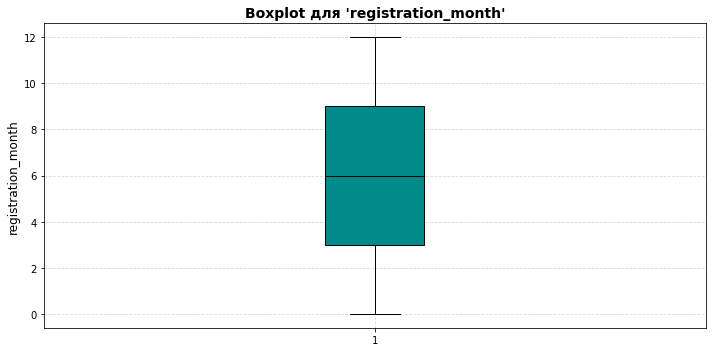

count    353691.000000
mean          5.719413
std           3.724834
min           0.000000
25%           3.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: registration_month, dtype: float64

In [37]:
plot_bar(data_auto, "registration_month")
plot_box(data_auto, "registration_month")
data_auto["registration_month"].describe()

Мы видим, что больше всего значений приходится на аномальную категорию 0 месяцев. Следует рассмотреть эти значения.

In [38]:
check_outliers(data_auto, "registration_month", 0, 0)

Доля значений внутри диапазона [0, 0]: 10.48%


Доля таких значений велико, поэтому следует их заменить средним.

In [39]:
data_auto = replace_outliers(data_auto, "registration_month", 0, 0, 1)

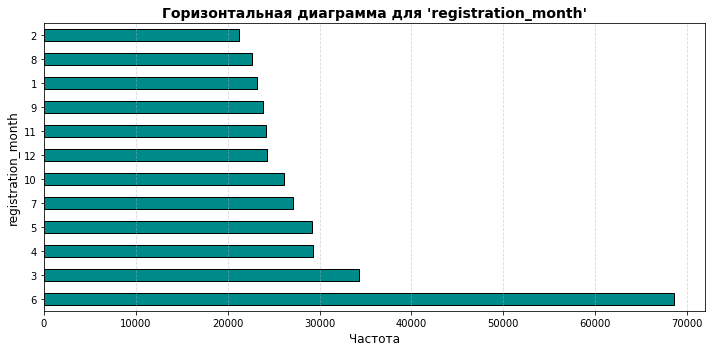

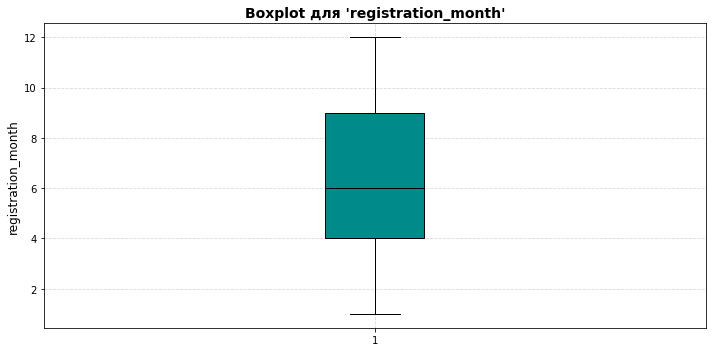

count    353691.000000
mean          6.348318
std           3.171491
min           1.000000
25%           4.000000
50%           6.000000
75%           9.000000
max          12.000000
Name: registration_month, dtype: float64

In [40]:
plot_bar(data_auto, "registration_month")
plot_box(data_auto, "registration_month")
data_auto["registration_month"].describe()

Медиана и среднее значение регистрации месяца равны 6(июнь). Самым популярным месяцем является также июнь, потому что многие аномальные значения были заменены июнем. Далее идут март, апрель, май и июль. Можно сказать, что есть тенденция регистрировать машины в первой половине года, а особенно весной. 

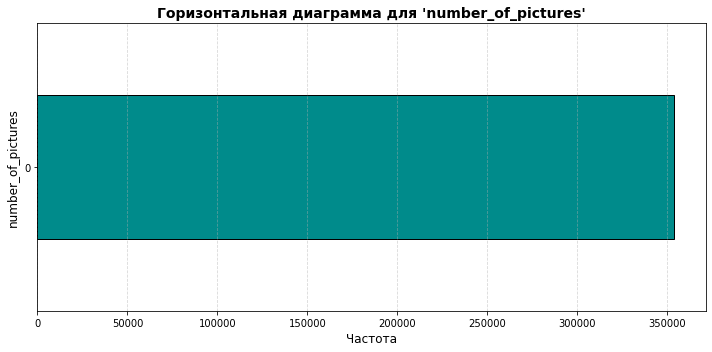

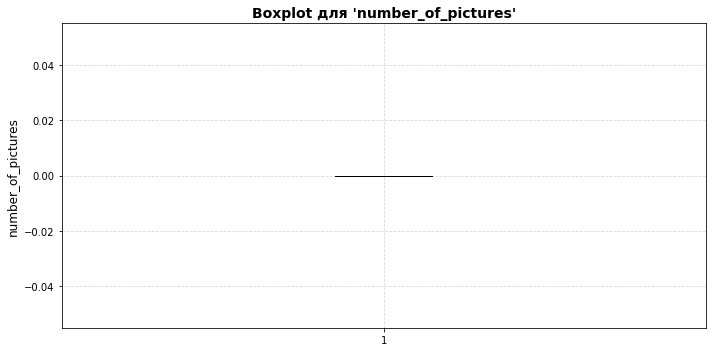

count    353691.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: number_of_pictures, dtype: float64

In [41]:
plot_bar(data_auto, "number_of_pictures")
plot_box(data_auto, "number_of_pictures")
data_auto["number_of_pictures"].describe()

У всех автомобилей в датасете 0 фотографий. Данный признак не влияет на целевой.

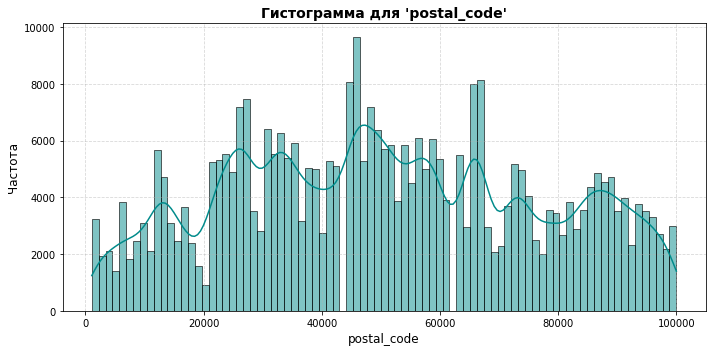

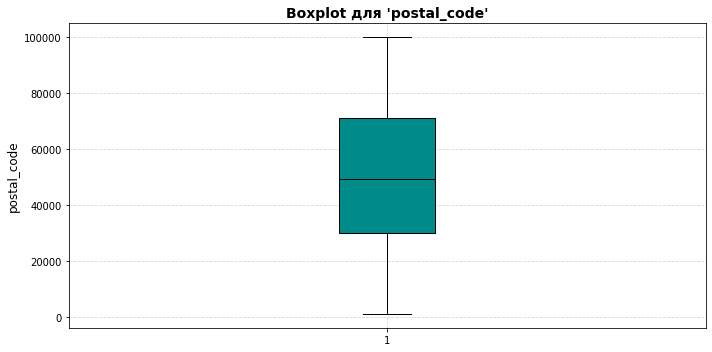

count    353691.000000
mean      50516.441962
std       25780.936927
min        1067.000000
25%       30165.000000
50%       49413.000000
75%       71083.000000
max       99998.000000
Name: postal_code, dtype: float64

In [42]:
plot_hist(data_auto, "postal_code")
plot_box(data_auto, "postal_code")
data_auto["postal_code"].describe()

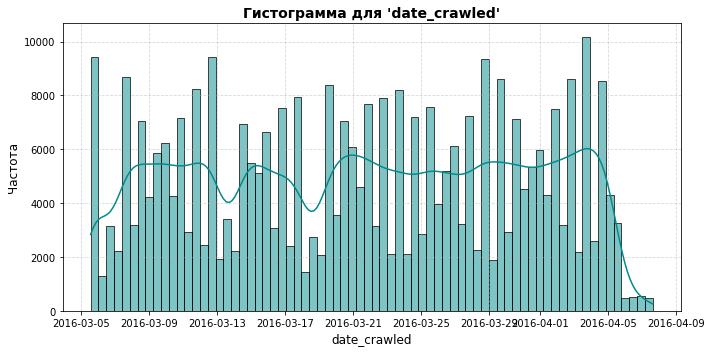

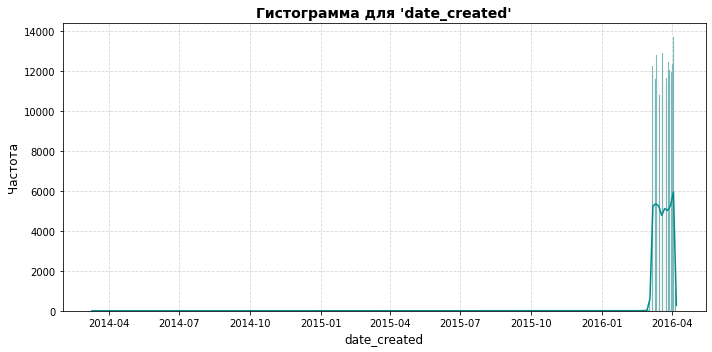

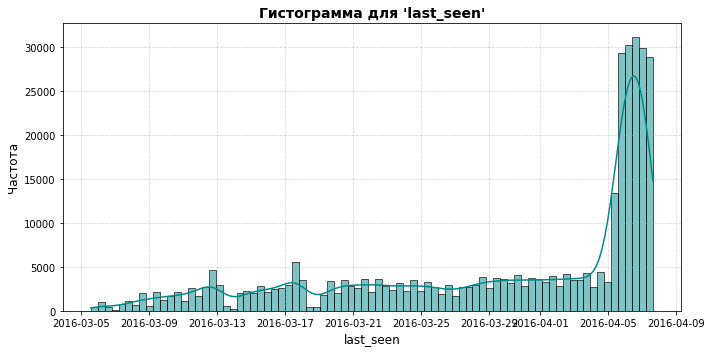

In [43]:
plot_hist(data_auto, "date_crawled")
plot_hist(data_auto, "date_created")
plot_hist(data_auto, "last_seen")

Почтовый индекс владельца ни на что не влияет и не предлагает нам никакой полезной информации. Тоже самое касается date_crawled, date_created, last_seen. Тем не менее, по date_crawled стало понятно, что если данные были выгруженны в 2016 году, то в датасете никак не могут присутствовать данные позже 2016 года. Надо исправить предыдущую ошибку

In [44]:
check_outliers(data_auto, "registration_year", 2017, 9999)

Доля значений внутри диапазона [2017, 9999]: 4.07%


Таких значений тоже очень много, поэтому следует их заменить

In [45]:
data_auto = replace_outliers(data_auto, "registration_year", 2017, 9999, 0)

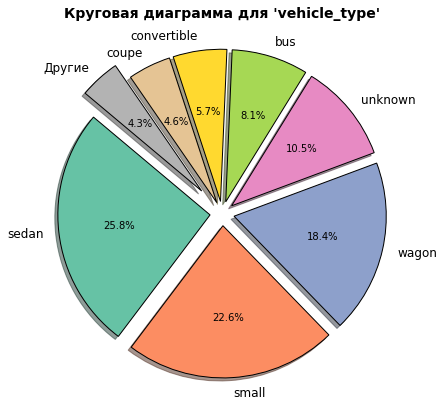

In [46]:
plot_pie(data_auto, "vehicle_type")

Тип автомобильного кузова: больше всего машин с sedan(25.8%), small(22.6%), wagon(18.4%)

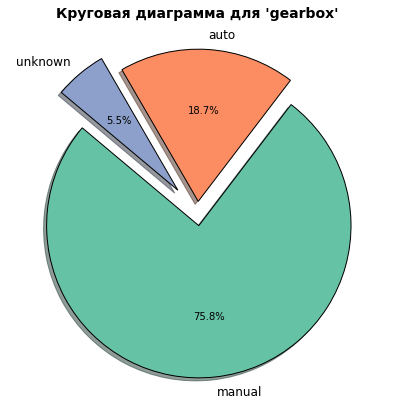

In [47]:
plot_pie(data_auto, "gearbox")

Тип коробки передач: больше всего машин с manual(75.8%), auto(18.7%)

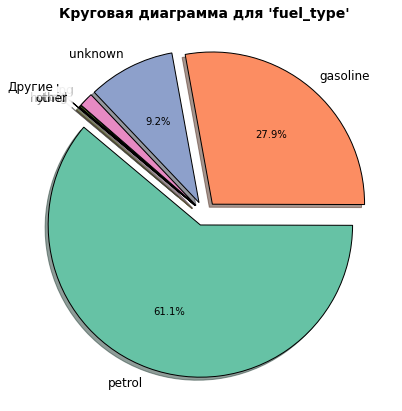

In [48]:
plot_pie(data_auto, "fuel_type")

Вид топлива: больше всего машин с petrol(61.1%), gasoline(27.9%)

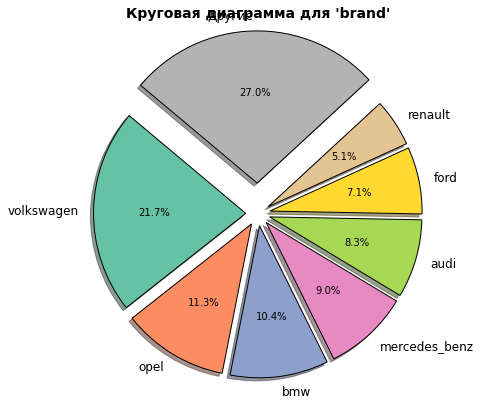

In [49]:
plot_pie(data_auto, "brand")

Бренд автомобиля: больше всего машин бренда volkswagen(21.7%), opel(11.3%), bmw(10.4%)

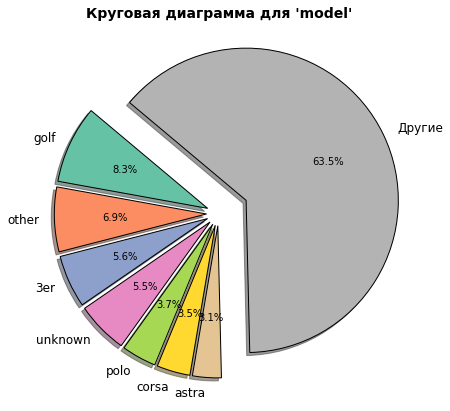

In [50]:
plot_pie(data_auto, "model")

Модель автомобиля: больше всего машин модели golf(8.3%), 3er(5.6%), polo(3.7%)

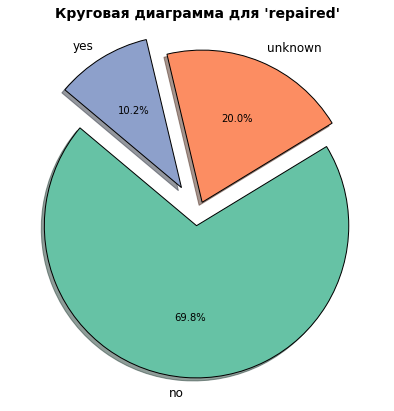

In [51]:
plot_pie(data_auto, "repaired")

Только 69.8% машин не были в ремонте. Тем не менее, 10.2% были подверженны ремонту, а судьба оставшихся неизвестна.

**Итоги по исследовательскому анализу данных:**
* С увеличением цены машины понижается их количество, что не вызывает никаких отклонений от нормы. Машины, которые стоят больше 14500 посчитались выбросами из-за маленького количества дорогих машин по отношению к общему. Их мы обрабатывать не будем, но присмотримся к слишком дешевым машинам, которые стоят 0. Cреднее значение равно 4416, а медиана 2700. Максимальное и минимальное значение 20000 и 0 евро.
* Самым частым годом регистрации машины является 2000, а следом 1999, 2005, 2006 и 2001.
* Значения мощности автомобиля выше 2000 было принято считать за выбросы. Их доля составляет 0.03%. В тоже время доля значений меньше 50 составляет 14.24%. Из-за большой доли таких аномальных значений они были заменены средним значением. Медиана и среднее значение равны 123.69 и 123.69. Максимальное и минимальное значения равны 51 и 1999 л.с
* Никаких аномальных значений в пробеге не наблюдается. Присутствует много значений с большим пробегом и мало значений с маленьким пробегом. Медиана и среднее значение равны 128335 и 15000. Максимальное и минимальное значения равны 5000 и 15000 л.с
* Медиана и среднее значение регистрации месяца равны 6(июнь). Самым популярным месяцем является также июнь, потому что многие аномальные значения были заменены июнем. Далее идут март, апрель, май и июль. Можно сказать, что есть тенденция регистрировать машины в первой половине года, а особенно весной. 
* У всех автомобилей в датасете 0 фотографий. Данный признак не влияет на целевой.
* Почтовый индекс владельца ни на что не влияет и не предлагает нам никакой полезной информации. Тоже самое касается date_crawled, date_created, last_seen. Тем не менее, по date_crawled стало понятно, что если данные были выгруженны в 2016 году, то в датасете никак не могут присутствовать данные позже 2016 года.
* Тип автомобильного кузова: больше всего машин с sedan(25.8%), small(22.6%), wagon(18.4%)
* Тип коробки передач: больше всего машин с manual(75.8%), auto(18.7%)
* Вид топлива: больше всего машин с petrol(61.1%), gasoline(27.9%)
* Бренд автомобиля: больше всего машин бренда volkswagen(21.7%), opel(11.3%), bmw(10.4%)
* Модель автомобиля: больше всего машин модели golf(8.3%), 3er(5.6%), polo(3.7%)
* Только 69.8% машин не были в ремонте. Тем не менее, 10.2% были подверженны ремонту, а судьба оставшихся неизвестна.

# Корреляционный анализ признаков


In [52]:
num_cols = []

In [53]:
for col in data_auto.columns:
    if ((data_auto[col].dtype == 'int64' or data_auto[col].dtype == 'float64') and (col != 'postal_code')):
        num_cols.append(col)

In [54]:
phik_train = data_auto.drop(columns = ["date_crawled", "last_seen", "postal_code", "date_created", "number_of_pictures"])

In [55]:
phik_overview = phik_train.phik_matrix(interval_cols=num_cols)

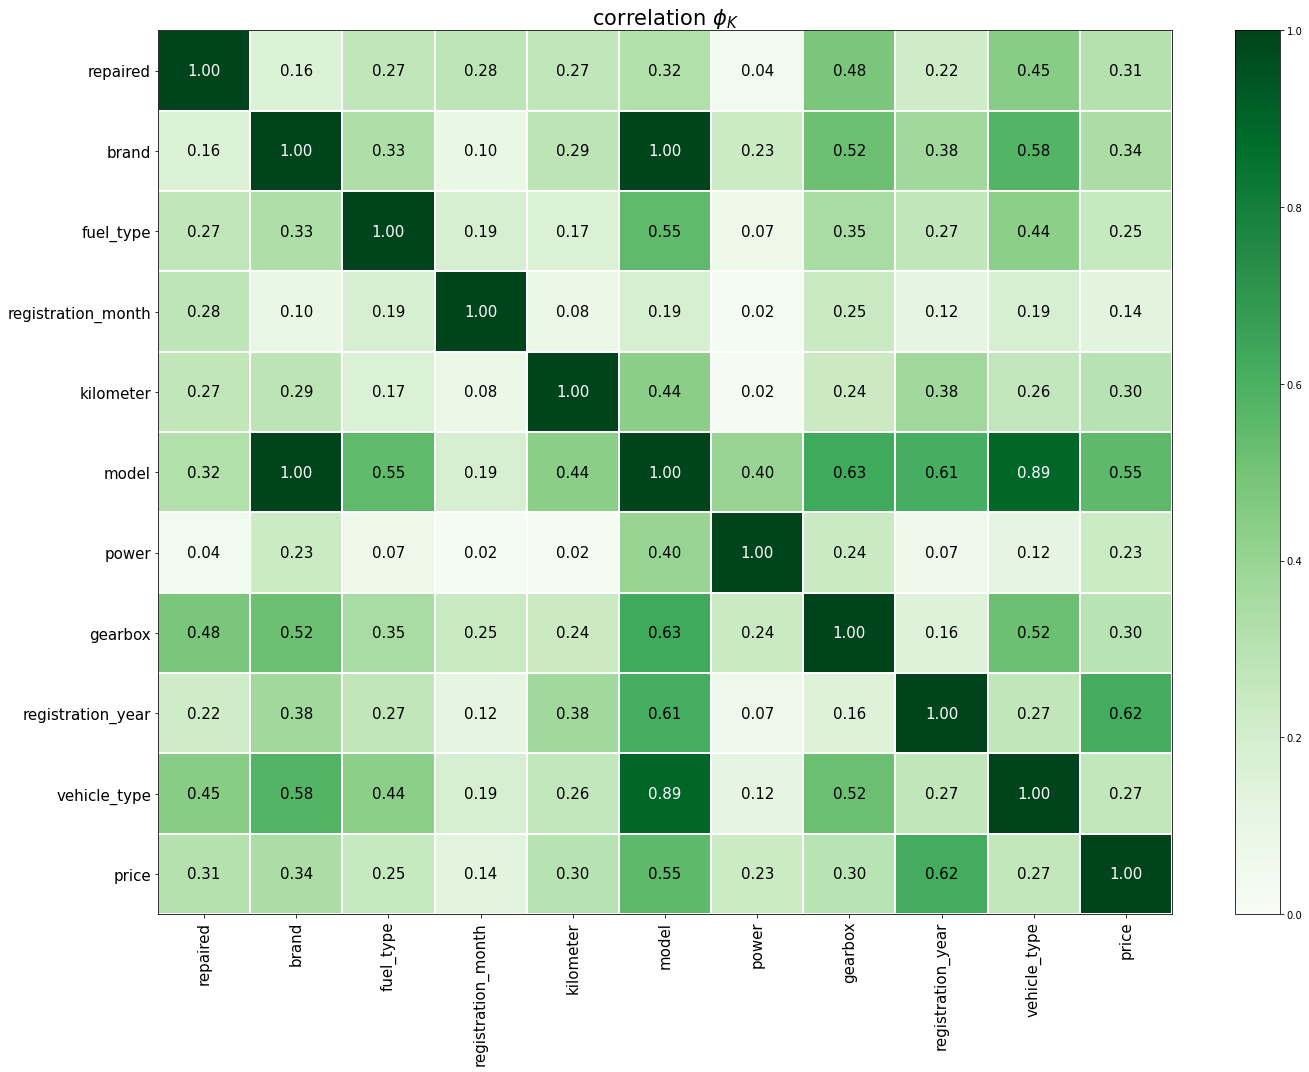

In [56]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

**Итоги по корреляционному анализу признаков:**
* Целевой признак price больше всего зависит от registration_year(0.62), model(0.55), brand(0.34) и repaired(0.31)
* Model и brand имеют высокий показатель мультиколлинеарность 1.0, что логично для автомобиля. Для нашей модели мы оставим только model
* Также стоит исключить vehicle_type, так как присутствует сильная связь с model(0.89)
* Признаки date_crawled, date_created, last_seen, postal_code, number_of_pictures не несут никакой пользы для модели

## Обучение моделей

In [57]:
pip install -U scikit-learn --quiet

Note: you may need to restart the kernel to use updated packages.


In [58]:
!pip install --upgrade scikit-learn

In [59]:
data = data_auto.drop(['date_crawled', 'date_created', 'last_seen', 'postal_code', 'number_of_pictures', 'brand', 'vehicle_type'], axis = 1)

In [60]:
display(data.head())

,price,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,repaired
0,480.0,1993.0,manual,123.694064,golf,150000,6,petrol,unknown
1,18300.0,2011.0,manual,190.000000,unknown,125000,5,gasoline,yes
2,9800.0,2004.0,auto,163.000000,grand,125000,8,gasoline,unknown
3,1500.0,2001.0,manual,75.000000,golf,150000,6,petrol,no
4,3600.0,2008.0,manual,69.000000,fabia,90000,7,gasoline,no


In [61]:
X = data.drop(['price'], axis=1)
y = data['price']

In [62]:
ohe_columns = ['model', 'gearbox', 'fuel_type', 'repaired', 'registration_month']
num_columns = ['registration_year', 'power', 'kilometer']

In [63]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size = 0.25,
    random_state=RANDOM_STATE
)

In [64]:
encoder = OneHotEncoder(drop = 'first', handle_unknown = 'error', sparse_output = False)
X_train_ohe = encoder.fit_transform(X_train[ohe_columns])
X_test_ohe = encoder.transform(X_test[ohe_columns])
encoder_col_names = encoder.get_feature_names_out()
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

In [65]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_columns])
X_test_scaled = scaler.transform(X_test[num_columns])
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_columns)

In [66]:
X_train_linear = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test_linear = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [67]:
model_lr = LinearRegression()
cv_results_lr = cross_validate(
    model_lr,
    X=X_train_linear,
    y=y_train,
    scoring='neg_root_mean_squared_error',
    cv=5,
    return_train_score=False
)
rmse_lr = -cv_results_lr['test_score']
fit_time_lr = cv_results_lr['fit_time']
score_time_lr = cv_results_lr['score_time']

print("Linear Regression RMSE:", rmse_lr.mean())
print("Linear Regression fit time (avg):", fit_time_lr.mean())
print("Linear Regression score time (avg):", score_time_lr.mean())

Linear Regression RMSE: 2899.7888139247216
Linear Regression fit time (avg): 16.115540075302125
Linear Regression score time (avg): 0.1095743179321289


In [68]:
categ_cols = ohe_columns

In [69]:
X_train_lgbm = X_train.copy()
X_train_lgbm[categ_cols] = X_train[categ_cols].astype('category')

In [70]:
X_test_lgbm = X_test.copy()
X_test_lgbm[categ_cols] = X_test[categ_cols].astype('category')

In [71]:
model_lgbm = LGBMRegressor(objective='root_mean_squared_error', verbose=-1)
param_grid = {
    'learning_rate': [0.1, 0.4, 0.6],  
    'max_depth': [1, 2, 4]
}

In [72]:
random_search_lgbm = RandomizedSearchCV(
    estimator=model_lgbm, 
    param_distributions=param_grid, 
    scoring='neg_root_mean_squared_error', 
    cv=5,
    n_iter=9,
    return_train_score=False
)

In [73]:
random_search_lgbm.fit(X_train_lgbm, y_train)

RandomizedSearchCV(cv=5,
                   estimator=LGBMRegressor(objective='root_mean_squared_error',
                                           verbose=-1),
                   n_iter=9,
                   param_distributions={'learning_rate': [0.1, 0.4, 0.6],
                                        'max_depth': [1, 2, 4]},
                   scoring='neg_root_mean_squared_error')

In [74]:
best_lgbm_model = random_search_lgbm.best_estimator_
best_params_lgbm_model = random_search_lgbm.best_params_
best_score_lgbm_model = -random_search_lgbm.best_score_

In [75]:
best_lgbm_model = random_search_lgbm.best_estimator_

In [76]:
cv_results = random_search_lgbm.cv_results_
best_index = random_search_lgbm.best_index_
mean_fit_time_lgbm = cv_results['mean_fit_time'][best_index]
mean_score_time_lgbm = cv_results['mean_score_time'][best_index]

In [77]:
print("Лучшие параметры: ", best_params_lgbm_model)
print("Среднее значение RMSE:", best_score_lgbm_model)
print("LGBM fit time (avg):", mean_fit_time_lgbm)
print("LGBM score time (avg):", mean_score_time_lgbm)

Лучшие параметры:  {'max_depth': 4, 'learning_rate': 0.4}
Среднее значение RMSE: 1906.6452181520235
LGBM fit time (avg): 2.9544340133666993
LGBM score time (avg): 0.36415534019470214


## Анализ моделей

In [78]:
results_df = pd.DataFrame({
    'Model': ['Linear Regression', 'LGBM Regressor'],
    'Mean RMSE': [rmse_lr.mean(), best_score_lgbm_model],
    'Fit Time (s)': [fit_time_lr.mean(), mean_fit_time_lgbm],
    'Score Time (s)': [score_time_lr.mean(), mean_score_time_lgbm]
})

display(results_df)

,Model,Mean RMSE,Fit Time (s),Score Time (s)
0,Linear Regression,2899.788814,16.115540,0.109574
1,LGBM Regressor,1906.645218,2.954434,0.364155


На кросс-валидации мы заметили, что модель LightGBM превосходит модель линейной регрессии во всем.

Поэтому мы выберем LightGBM как нашу лучшую модель и проверим ее на тестовой выборке. Лучшие гиперпараметры у нас уже имеются

In [79]:
start_fit = time.time()
best_lgbm_model.fit(X_train_lgbm, y_train)
end_fit = time.time()
fit_duration = end_fit - start_fit

start_pred = time.time()
y_pred_lgbm = best_lgbm_model.predict(X_test_lgbm)
end_pred = time.time()
pred_duration = end_pred - start_pred

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))

print(f"Время обучения на всей обучающей выборке: {fit_duration}")
print(f"Время предсказания на тестовой выборке: {pred_duration}")
print(f"RMSE на тестовой выборке: {rmse_test}")

Время обучения на всей обучающей выборке: 3.207859516143799
Время предсказания на тестовой выборке: 0.5996849536895752
RMSE на тестовой выборке: 1892.8291937987676


**Итоги по анализу моделей:**

На кросс-валидации мы заметили, что модель LightGBM превосходит модель линейной регрессии

Поэтому мы выберем LightGBM как нашу лучшую модель и проверим ее на тестовой выборке. Лучшие гиперпараметры у нас уже имеются

* Время обучения на всей обучающей выборке: 3.220496892929077
* Время предсказания на тестовой выборке: 0.6069636344909668
* RMSE на тестовой выборке: 1892.8291937987676


## Итоговые выводы

**Итоги по обзору данных:**
* Присутствуют пропуски в vehicle_type, gearbox, model, fuel_type, repaired
* Присутствуют проблемы с форматом столбцов данных

**Итоги по предобработке данных:**
* Тип данных был приведен в верный формат
* Названия столбцов были переведены в змеиный регистр
* Пропуски были заменены заглушкой unknown
* Явные дубликаты были устранены
* Неявных дубликатов нет

**Итоги по исследовательскому анализу данных:**
* С увеличением цены машины понижается их количество, что не вызывает никаких отклонений от нормы. Машины, которые стоят больше 14500 посчитались выбросами из-за маленького количества дорогих машин по отношению к общему. Их мы обрабатывать не будем, но присмотримся к слишком дешевым машинам, которые стоят 0. Cреднее значение равно 4416, а медиана 2700. Максимальное и минимальное значение 20000 и 0 евро.
* Самым частым годом регистрации машины является 2000, а следом 1999, 2005, 2006 и 2001.
* Значения мощности автомобиля выше 2000 было принято считать за выбросы. Их доля составляет 0.03%. В тоже время доля значений меньше 50 составляет 14.24%. Из-за большой доли таких аномальных значений они были заменены средним значением. Медиана и среднее значение равны 123.69 и 123.69. Максимальное и минимальное значения равны 51 и 1999 л.с
* Никаких аномальных значений в пробеге не наблюдается. Присутствует много значений с большим пробегом и мало значений с маленьким пробегом. Медиана и среднее значение равны 128335 и 15000. Максимальное и минимальное значения равны 5000 и 15000 л.с
* Медиана и среднее значение регистрации месяца равны 6(июнь). Самым популярным месяцем является также июнь, потому что многие аномальные значения были заменены июнем. Далее идут март, апрель, май и июль. Можно сказать, что есть тенденция регистрировать машины в первой половине года, а особенно весной. 
* У всех автомобилей в датасете 0 фотографий. Данный признак не влияет на целевой.
* Почтовый индекс владельца ни на что не влияет и не предлагает нам никакой полезной информации. Тоже самое касается date_crawled, date_created, last_seen. Тем не менее, по date_crawled стало понятно, что если данные были выгруженны в 2016 году, то в датасете никак не могут присутствовать данные позже 2016 года.
* Тип автомобильного кузова: больше всего машин с sedan(25.8%), small(22.6%), wagon(18.4%)
* Тип коробки передач: больше всего машин с manual(75.8%), auto(18.7%)
* Вид топлива: больше всего машин с petrol(61.1%), gasoline(27.9%)
* Бренд автомобиля: больше всего машин бренда volkswagen(21.7%), opel(11.3%), bmw(10.4%)
* Модель автомобиля: больше всего машин модели golf(8.3%), 3er(5.6%), polo(3.7%)
* Только 69.8% машин не были в ремонте. Тем не менее, 10.2% были подверженны ремонту, а судьба оставшихся неизвестна.

**Итоги по корреляционному анализу признаков:**
* Целевой признак price больше всего зависит от registration_year(0.62), model(0.55), brand(0.34) и repaired(0.31)
* Model и brand имеют высокий показатель мультиколлинеарность 1.0, что логично для автомобиля. Для нашей модели мы оставим только model
* Также стоит исключить vehicle_type, так как присутствует сильная связь с model(0.89)
* Признаки date_crawled, date_created, last_seen, postal_code, number_of_pictures не несут никакой пользы для модели

**Итоги по анализу моделей:**

На кросс-валидации мы заметили, что модель LightGBM превосходит модель линейной регрессии

Поэтому мы выберем LightGBM как нашу лучшую модель и проверим ее на тестовой выборке. Лучшие гиперпараметры у нас уже имеются

* Время обучения на всей обучающей выборке: 3.220496892929077
* Время предсказания на тестовой выборке: 0.6069636344909668
* RMSE на тестовой выборке: 1892.8291937987676


**По всем параметрам лучшей моделью является LightGBM, поэтому я рекомендую именно ее**